# Cascade-Correlation,  a Forgotten Learning Architecture

#### How the first 'deep learning' approach outperformed classical neural networks in 1990.

In 1990, a dynamic neural network architecture by Scott E. Fahlman and Christian Lebiere called "Cascade-Correlation" [1] outperformed static neural networks in training speed, accuracy, and size. In a [recent lecture](https://www.youtube.com/watch?v=k2mPEUZH978), Fahlman actually called it the first approach to use something like 'deep' learning.
With this algorithm, they successfully competed on the 'two spirals' categorization task and artificial grammar learning problems.

And yet their work was largely forgotten or treated as a side note of history.
Even though the idea itself is quite close in spirit to what we, by now, refer to as the ['boosting'](https://en.wikipedia.org/wiki/Boosting_(machine_learning)) family of machine learning algorithms - techniques that perform [better than deep learning](https://www.youtube.com/watch?v=9GCEVv94udY) on certain sets of problems. These - just like Cascade-Correlation - are based on the idea of iteratively improving a classifier by stacking specialized learners, trained one at a time.

More than enough reason to understand and implement Fahlman's approach - and put it to the test on various domains and challenges! Let's investigate if, where, and how it can still compete with modern machine learning tools.

---

_This article is part one of a series with a focus on (Recurrent) Cascade-Correlation._

_In this first part, we'll look in detail on how a simple, forward-only Cascade-Correlation (or CasCor for short) network can be implemented using Python and PyTorch. We'll also see some results of applying it to a simplistic problem domain._

_In the next parts, we'll investigate how to automate and optimize the algorithm using batching. We'll also implement and train a recurrent version of it and benchmark CasCor against existing solutions._

_To follow along with this article, you should be familiar with how neural networks can be trained using back-propagation of the loss gradient (as of 2020, a widely used approach). That is, you should understand how the gradient is usually calculated and applied to the parameters of a network to try to iteratively achieve convergence of the loss to a global minimum._

---

## Part 1: Cascade Correlation

Without further ado, let's implement a simplistic version of CasCor! Since we are working with Python, we need to import some basics and PyTorch:

In [1]:
import numpy as np
from numpy.random import Generator, PCG64
import matplotlib.pyplot as plt
import torch

rnd = Generator(PCG64(12345))
# To be used like: numpy.random, e.g. rnd.random(2, 3) produces a random (2,3) array
# We'll use this to generate initial weights for our neurons

### Overview

The CasCor algorithm starts off with a one-layer network (only output neurons). It then follows these steps:

1. Train (only!) the output neurons until reaching a plateau
2. If the residual error is good enough, stop;
3. Otherwise, freeze all weights of the existing network
4. Then train a new hidden neuron, by optimizing the correlation between its output and the last measured residual error (see below)
5. Go back to step 1 - rinse & repeat

Step 4. is the most important and most complicated part of CasCor, illustrated also in the figure below. 
Until the training has finished, the hidden neuron is disconnected from the network.
We statically feed all the original inputs and the values of earlier layers as a weighted sum to its activation function.
Then the training algorithm optimizes the neuron's weights to achieve the best possible correlation of its output value with the sample set residual error, measured in an earlier iteration.

To train for optimum correlation, we will need to use the correlation measure instead of some standard loss function, but more on that later.

After the training finished, we can add the hidden neuron to the network. The output neurons will now receive its value as an additional input, and we need to train their new weights, so we jump back to step 1.

Fahlman's paper illustrates the process of adding a hidden neuron, like this:

![CasCor network with new hidden node](img/cascor_layer_add.png)

#### When adding a new hidden neuron, only the new weights (red squares) are iterated. Here, the arrows are weighted sums fed into the circle depicting the activation function. (Graphic translated and adapted from [Wikipedia](https://de.wikipedia.org/wiki/Datei:Cascar.png))

In this article, we focus on the two major parts of CasCor: Steps 1. and 4., i.e. training the outputs and training a hidden neuron. The rest we'll simply do manually.

### Test Set

For simplicity, we use a 2D categorization task for testing (It's easier to debug). Our network will thus have 2 input dimensions (the coordinates of the grid) and 1 output dimension (a value between 0 and 1).

We'll train on the following data sets (without test sets for now), where 0 values are black and 1 values are white:

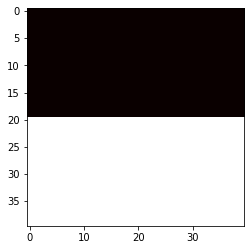

In [2]:
target1 = np.concatenate((np.zeros((20,40)), np.ones((20,40))), axis=0)
                         
plt.imshow(target1, cmap='hot', interpolation='nearest')
plt.show()

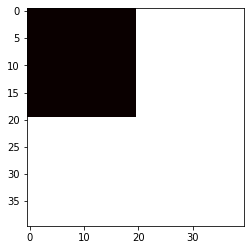

In [3]:
target2 = np.concatenate(
    (np.concatenate((np.zeros((20,20)), np.ones((20,20))), axis=1),
     np.ones((20,40))), axis=0)
                         
plt.imshow(target2, cmap='hot', interpolation='nearest')
plt.show()

To actually feed the input and output into our training function, we also need to convert these to a 'long' form and add a static bias value of 1.

Plus, testing showed that CasCor and quickprop perform better when the inputs are normalized, so let's do that as well:

In [4]:
def create_trainset(target):
    idxs = np.asarray(list(np.ndindex(target.shape)))
    # Normalize inputs
    idxs = idxs / np.linalg.norm(idxs, axis=0)
    # Add bias vector:
    x = np.ones((idxs.shape[0], idxs.shape[1]+1))
    x[:,:-1] = idxs

    y = target.reshape((-1, 1))
    
    return x, y

### Quickprop

To train the units in the CasCor network, they use a technique that was also invented by Fahlman in 1988 [2] called quickprop.

Quickprop is an alternative to back-propagation that uses a variation of [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method). For more info on this aside from the original paper, [this useful blog post](https://www.bonaccorso.eu/2017/09/15/quickprop-an-almost-forgotten-neural-training-algorithm/) by Giuseppe Bonaccorso also describes it quite well.

_Note that quickprop is not strictly necessary to implement CasCor. However, to stick close to the original paper and for maximized learning, we'll use it here as well. It is actually an interesting topic all on its own, and I encourage you to investigate it!_

_If you couldn't care less about quickprop, skip ahead to the next section and treat any further mention of it simply as 'training neuron weights based on given input & expected output pairs'._

Our implementation is based on the blog post - but since we don't want to focus on quickprop in this article, we'll just peek at some adjustments to their code instead of diving into the maths.

**Flexibility.** The code from the post uses a fixed activation and loss function and statically implements their gradient. For CasCor, we need to be a bit more flexible (at least when it comes to the loss) so we pass these functions as parameters.

**Automatic Gradient Computation.** Since the activation and loss function are now variable, we'll run into trouble when trying to build their gradient. But, using PyTorch, we can easily skip over that and let the `autograd` do the heavy lifting.

**Convergence.** Giuseppe's code tests the change in weights per iteration to determine convergence. Some quick tests found that to be troublesome since it often seems to get stuck on saddle points and local minima. So instead of that, we'll use the residual error.

Specifically, we'll calculate a running mean of the residual error, and check if the difference in mean per iteration is smaller than a given `tolerance`.

Last but not least, if the error diverges or converges too slowly, quickprop simply gives up after a certain amount of iterations (it runs out of `patience`, see the function parameter).

In [5]:
# Param shapes: x_: (n,i), y_: (n,o), weights: (i,o)
#   Where n is the size of the whole sample set, i is the input count, o is the output count
#   We expect x_ to already include the bias
# Returns: trained weights, last prediction, last iteration, last loss
# NB: Differentiation is done via torch
def quickprop(x_, y_, weights,
              activation=torch.nn.Sigmoid(),
              loss=torch.nn.MSELoss(),
              learning_rate=1e-4,
              tolerance=1e-6,
              patience=20000,
              debug=False):
    # Box params as torch datatypes
    x = torch.Tensor(x_)
    y = torch.Tensor(y_)
    w = torch.Tensor(weights)

    # Keep track of mean residual error values (used to test for convergence)
    L_mean = 1
    L_mean_prev = 1
    L_mean_diff = 1
    
    # Keep track of loss and weight gradients
    dL = torch.zeros(w.shape)
    dL_prev = torch.ones(w.shape)
    dw_prev = torch.ones(w.shape)

    i = 0
    predicted = []

    # This algorithm expects the mean losses to converge or the patience to run out...
    while L_mean_diff > tolerance and i < patience:
        # Prep iteration
        i += 1
        dL_prev = dL.clone()
        # NB: The following can probably done better with torch.no_grad(), but I couldn't make it work
        w_var = torch.autograd.Variable(torch.Tensor(w), requires_grad=True)
        
        # Calc forward and loss
        predicted = activation(torch.mm(x, w_var))
        L = loss(predicted, y)
        
        # Keep track of losses and use as convergence criterion if mean doesn't change much     
        L_mean = L_mean + (1/(i+1))*(L.detach().numpy() - L_mean)
        L_mean_diff = np.abs(L_mean_prev - L_mean)
        L_mean_prev = L_mean
        
        # Calc differential and do the weight update
        L.backward()
        
        dL = w_var.grad.detach() # =: partial(L) / partial(W)
        dw = dw_prev * dL / (dL_prev - dL + 1e-10) # Prevent div/0
        
        dw_prev = dw.clone()
        
        w += learning_rate * dw
        
        if debug and i % 100 == 99:
            print("Residual           ", L.detach().numpy())
            print("Residual mean      ", L_mean)
            print("Residual mean diff ", L_mean_diff)
        
    return w.detach().numpy(), predicted.detach().numpy(), i, L.detach().numpy()

### Output Training

With quickprop implemented, let's get to the fun part!

CasCor starts with a one layer network, i.e. we will be using a single output neuron and connect that to our input (and bias).

To start training this neuron, we take sets of input (`x`) and output (`y`) samples and create newly initialized (random) weights, all of which we feed into quickprop.

_Note that this approach does not care whether the network is single-layer or deeper - since we are_ only _training the output weights, we could also have run the inputs through a number of hidden layers and use that as the `x` for the training._

In [6]:
# The vector x is the values from the earlier hidden/input layers per each sample
# Parameter shapes: x - (n,i), y - (n,o)
#   Where n is the size of the whole sample set, i is the input count, o is the output count
#   We expect x_ to already include the bias
def train_outputs(x, y):
    # Next we need to create a weight vector with the right shape
    n, i = x.shape
    n, o = y.shape
    
    weights = rnd.uniform(-0.01, 0.01, size=(i, o))
    
    # And run through the training
    weights, predicted, i, loss = quickprop(x, y, weights)
    
    return weights, predicted

Let's test this with the training sets:

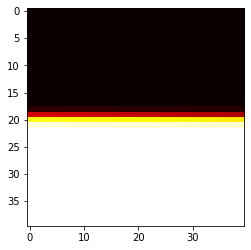

In [15]:
x, y = create_trainset(target1)
w, pred = train_outputs(x, y)

plt.imshow(pred.reshape(target1.shape), cmap='hot', interpolation='nearest')
plt.show()

Looks good for the simple one!

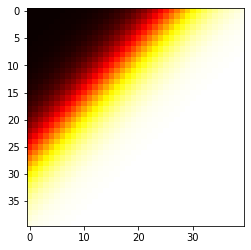

In [16]:
x, y = create_trainset(target2)
w, pred = train_outputs(x, y)

plt.imshow(pred.reshape(target1.shape), cmap='hot', interpolation='nearest')
plt.show()

Unsurprisingly, this doesn't match up so well. But it is a good enough approximation for now.

### Hidden Neuron Training

As we have seen, our simple one-neuron model approximates the second shape with quite a bit of error.
To achieve a better fit, we'll need to add hidden layer(s).

When we add a hidden neuron, we:

1. Freeze all other parameters (including output)
2. Run the training sample forward through the net and use the input values and other hidden unit values as the input of the new unit
3. Train the new neuron such that its value best correlates with the residual errors calculated in an earlier run

The covariance function S (we'll use it instead of correlation; more details on that in [1]) is given by:

$$
\begin{align}
V_p &= \phi \ (I_p \cdot W) \\
S &= \sum_{o} \left| \sum_{p} (V_p - \bar{V}) (E_{o,p} - \bar{E_o}) \right| \\
\end{align} 
$$

Where phi is the activation function of the neuron, V is the value of it, and E is the residual error (the earlier prediction minus the actual target). The bar-terms are the means and o and p are indices of output values and samples respectively.

With this as our 'loss' function, we can simply run quickprop again.

_Note that in hindsight, using quickprop here was a bit dangerous, since it uses an approximation of the second-order derivative under the hood. This fails to be a good solution, since the first-order derivative of $S$ is not continuous due to the magnitude calculation. In the CasCor paper, Fahlman et al. actually use gradient ascent for training the neuron._

In [71]:
def train_hidden(x, y, predicted, debug=False):
    # Figure out how many weights we need
    n, i = x.shape
    
    # And initialize a weights matrix
    weights = torch.Tensor(rnd.uniform(-0.01, 0.01, size=(i, 1)))
    
    # Calculate the residuals for correlation
    err = torch.Tensor(y - predicted)
    err_mean = torch.mean(err, axis=0)
    err_corr = (err - err_mean)
    
    if debug:
        plt.imshow(err_corr.reshape(target1.shape), cmap='hot', interpolation='nearest')
        plt.show()
    
    # Create a custom loss function (S)
    def covariance(pred, target):
        pred_mean = torch.mean(pred, axis=0)
        # We want to try to maximize the absolute covariance, but quickprop will minimize its loss function
        # Therefore, we need to multiply by (-1) to guide the optimizer correctly
        loss = -torch.sum(torch.abs(torch.sum((pred - pred_mean)*(target), axis=0)), axis=0)
        return loss
        
    # Use quickprop to generate the weights based on the special loss function
    # We also need to pass in the residual errors as a target
    weights, predicted, i, loss = quickprop(x, err_corr, weights, loss=covariance)
    
    return weights, predicted

Let's run this with the one-layer net predictions (`pred`) of the last sample set!

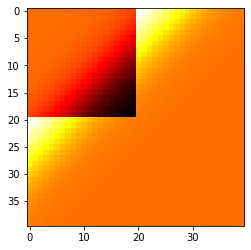

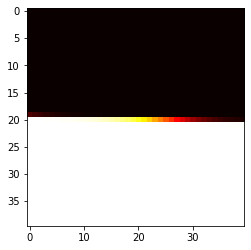

In [97]:
neuron_w, neuron_value = train_hidden(x, y, pred, debug=True)

plt.imshow(neuron_value.reshape(target1.shape), cmap='hot', interpolation='nearest')
plt.show()

This shows us pretty nicely where the error currently is biggest (very dark or very bright spots in the first plot) and what the neuron tries to do to correlate with that (second plot).

### Combining Hidden & Output Neurons

As the last step (of this article) we now train our output layer again, additionally based on the values (`neuron_value`) computed by our newly trained neuron.

To do so, we need to include these values as input to the output neurons (`x2`).

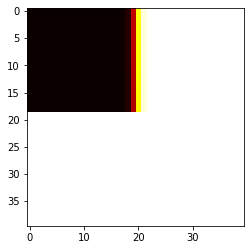

In [99]:
x2 = np.concatenate((x, neuron_value), axis=1)

w2, pred2 = train_outputs(x2, y)

plt.imshow(pred2.reshape(target1.shape), cmap='hot', interpolation='nearest')
plt.show()

Pretty!

The output neuron can now approximate the shape because it can base its regression on the additional value of the hidden neuron.
And since that correlates with the error we got from the earlier optimum, adding it has the effect of reducing the problem the output neuron has to solve by one dimension.

### Caveats

All the pictures are the result of executing the code snippets, however, what you cannot see is how often they were run until they generated those images.
Particularly, training the neuron only converges with a very low probability to the weights that produce the displayed values, i.e. I had to run the algorithm a couple of times until I got that particular output.  
This can presumably be attributed in part to the usage of quickprop here, since it relies on some properties of the loss function, like being continuous in its first derivative. As I mentioned above, Fahlman et. al. actually use gradient ascent in [1] to train the hidden neurons.

But there are more problems with quickprop that the simple implementation above does not address properly. From Fahlman's paper [2] and another, more recent comparison of quickprop with back-propagation [3] it becomes clear that a) it will need some more adjustments to yield good results more reliably, and b) it doesn't perform equally well on all domains. Specifically, it fails to compete with back-prop on bias and variance in some real-world image classification problems.

That said, a comparable network structure (1 hidden, 1 output neuron) trained with standard back-propagation and using the Adam optimizer never even converged to the above result during the test runs (it needed at least another neuron to converge to that), but that could be bad luck since it wasn't a controlled test setup.

Another problem of CasCor in general is the thinness of the network vs. its depth.
Since computers are very good at linear algebra (through the usage of GPUs), it is faster to run through broader networks that are less deep (i.e. that can better be represented as matrices), as compared to thinner and deeper networks, such as CasCor generates by default.

This is of course not so much of a problem with our little example, but it might become a problem when the generated network solves a more complicated task.

Which brings us to the next section:

### Future Improvements

As we have seen, this basic implementation of CasCor in fact works! :)

However, we are still missing a lot of boilerplate code that automates the process, and some optimization of the training method, to find a global optimum with higher probability.

That is why, in the next parts of this series, we'll see how we can:

- Automate the _output -> hidden -> output -> hidden -> ..._ training cycle
- Change quickprop to deliver more stable results and to train a set of new nodes instead of only one (and pick the best)
- Further improve that process to pick more than one node (i.e. have 'broader' layers)
- Change the problem domain to some more interesting/challenging ones (e.g. domains that can only be solved with deeper and/or recurrent networks)
- Benchmark it against other machine learning methods in a controlled setting

---

As mentioned earler, Quickprop deserves a more detailed look all on its own. For this reason, I wrote [a more in-depth article](https://towardsdatascience.com/quickprop-an-alternative-to-back-propagation-d9a78069e2a7) covering the maths behind it, a possible implementation and some improvements.

Part 2 of the series is currently in progress and will be linked here when it is published.  
All finished notebooks and code of this series are also [available on Github](https://github.com/ephe-meral/cascor).
Please feel encouraged to leave feedback and suggest improvements.

---

[1] S. E. Fahlman and C. Lebiere, [The cascade-correlation learning architecture](http://web.cs.iastate.edu/~honavar/fahlman.pdf) (1990), Advances in neural information processing systems (pp. 524–532)

[2] S. E. Fahlman, [An empirical study of learning speed in back-propagation networks](http://www.it.uu.se/edu/course/homepage/mil/vt11/handouts/fahlman.quickprop-tr.pdf) (1988), Carnegie Mellon University, Computer Science Department

[3] C. A. Brust, S. Sickert, M. Simon, E. Rodner and J. Denzler, [Neither Quick Nor Proper - Evaluation of QuickProp for Learning Deep Neural Networks](https://arxiv.org/pdf/1606.04333.pdf) (2016), arXiv preprint arXiv:1606.04333